# Simpsons and neural networks.


В данном ноутбуке представлено решение для задачи с Kaggle по классификации изображений героев одноименного сериала с помощью простых нейросетей и PyTorch. Настройки ниже - эксперименты с google colab и подходящей настройкой для работы с GPU.



### Установка зависимостей

In [1]:
!pip3 install wheel==0.34.1.

ERROR: tensorflow 2.4.0 has requirement wheel~=0.35, but you'll have wheel 0.34.1 which is incompatible.
  Found existing installation: wheel 0.36.2
    Uninstalling wheel-0.36.2:
      Successfully uninstalled wheel-0.36.2


In [2]:
!pip install torch==1.4.0 torchvision==0.5.0

     |████████████████████████████████| 753.4MB 21kB/s 
     |████████████████████████████████| 4.0MB 32.9MB/s 
  Found existing installation: torch 1.7.0+cu101
    Uninstalling torch-1.7.0+cu101:
      Successfully uninstalled torch-1.7.0+cu101
  Found existing installation: torchvision 0.8.1+cu101
    Uninstalling torchvision-0.8.1+cu101:
      Successfully uninstalled torchvision-0.8.1+cu101


In [3]:
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-1.4.0-{platform}-linux_x86_64.whl torchvision
import torch

In [4]:
import numpy as np
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [5]:
!pip uninstall -y Pillow
!pip install Pillow==5.3.0
#Нужно перезапустить среду

Uninstalling Pillow-7.0.0:
  Successfully uninstalled Pillow-7.0.0
     |████████████████████████████████| 2.0MB 3.6MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.


In [1]:
# необходима версия pillow  5.3.0
# удалим старую версию и установим новую
import PIL
print(PIL.PILLOW_VERSION)
# здесь должна быть версия 5.3.0. если это не так перезагрузите данный ноутбук:
# Menu > Runtime > Restart Runtime

5.3.0


In [2]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [3]:
!unzip -q /content/gdrive/My\Drive/journey-springfield.zip

In [4]:
!ls train

simpsons_dataset


In [5]:
!nvidia-smi
import torch
torch.cuda.is_available()

Fri Jan 15 13:04:54 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8    27W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

True

В тесте будет 990 картинок, наш датасет не сильно, но больше.



In [6]:
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms, models
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


In [7]:
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

In [8]:
class SimpsonsDataset(Dataset):
    def __init__(self, files, mode):
        super().__init__()
        self.files = sorted(files)
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])
        transform_tr = transforms.Compose([                              
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(20),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        #x = np.array(x / 255, dtype='float32')
        #x = transform(x)
        if self.mode == 'train':
          x = transform_tr(x)
        else:
          x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return image

In [9]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [10]:
TRAIN_DIR = Path('train/simpsons_dataset')
TEST_DIR = Path('testset/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [11]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [12]:
train_labels = [path.parent.name for path in train_files]
val_labels = [path.parent.name for path in val_files] 

In [13]:
def create_dct_path_labels(train_files, train_labels):
    dct_simpsons = {}
    for label_i in np.unique(train_labels).tolist():
        dct_simpsons[label_i] = []

    for path_i, label_i in zip(train_files, train_labels):
        dct_simpsons[label_i].append(path_i)

    return dct_simpsons

In [14]:
dct_path_train = create_dct_path_labels(train_files, train_labels)

In [15]:
for person in dct_path_train:
    if len(dct_path_train[person]) < 100:
        dct_path_train[person] = dct_path_train[person] * (100 // len(dct_path_train[person]))
        dct_path_train[person].extend(dct_path_train[person][:100 - len(dct_path_train[person])])

In [16]:
new_train_files = []

for person in dct_path_train:
    new_train_files.extend(dct_path_train[person])

new_train_label = [path.parent.name for path in new_train_files]

In [17]:
val_dataset = SimpsonsDataset(val_files, mode='val')
new_train_dataset = SimpsonsDataset(new_train_files, mode='train')

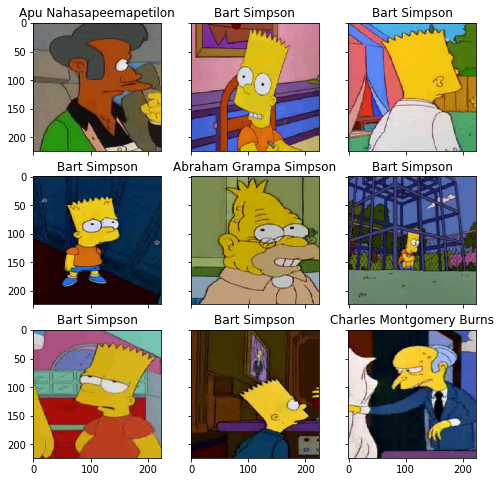

In [18]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

In [19]:
model = models.resnet50(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


In [20]:
model.fc = nn.Linear(2048, 42)
model = model.to(DEVICE)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [21]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [22]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [23]:
def train(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(new_train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters(), lr=0.0001)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, 'min')
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            scheduler.step(val_loss)
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
    return history

In [24]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

Запустим обучение сети.

In [25]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')
    
new_train_dataset = SimpsonsDataset(new_train_files, mode='train')

In [26]:
history = train(new_train_dataset, val_dataset, model=model.to(DEVICE), epochs=30, batch_size=64)

epoch:   0%|          | 0/30 [00:00<?, ?it/s]

loss 1.6487775148531147


epoch:   3%|▎         | 1/30 [08:24<4:04:00, 504.86s/it]


Epoch 001 train_loss: 1.6488     val_loss 0.4186 train_acc 0.5657 val_acc 0.8951
loss 0.3347122278808665


epoch:   7%|▋         | 2/30 [16:50<3:55:39, 505.00s/it]


Epoch 002 train_loss: 0.3347     val_loss 0.2630 train_acc 0.9123 val_acc 0.9329
loss 0.195341600443739


epoch:  10%|█         | 3/30 [25:15<3:47:20, 505.22s/it]


Epoch 003 train_loss: 0.1953     val_loss 0.4262 train_acc 0.9508 val_acc 0.8808
loss 0.15035775250987599


epoch:  13%|█▎        | 4/30 [33:41<3:38:59, 505.35s/it]


Epoch 004 train_loss: 0.1504     val_loss 0.1854 train_acc 0.9608 val_acc 0.9603
loss 0.11358899560049462


epoch:  17%|█▋        | 5/30 [42:10<3:30:59, 506.38s/it]


Epoch 005 train_loss: 0.1136     val_loss 0.1931 train_acc 0.9695 val_acc 0.9585
loss 0.09907844830949337


epoch:  20%|██        | 6/30 [50:38<3:22:46, 506.94s/it]


Epoch 006 train_loss: 0.0991     val_loss 0.1637 train_acc 0.9737 val_acc 0.9610
loss 0.09318691097788642


epoch:  23%|██▎       | 7/30 [59:08<3:14:37, 507.71s/it]


Epoch 007 train_loss: 0.0932     val_loss 0.2668 train_acc 0.9751 val_acc 0.9473
loss 0.07106913399804614


epoch:  27%|██▋       | 8/30 [1:07:35<3:06:04, 507.49s/it]


Epoch 008 train_loss: 0.0711     val_loss 0.2051 train_acc 0.9805 val_acc 0.9566
loss 0.07199196897195743


epoch:  30%|███       | 9/30 [1:16:00<2:57:24, 506.87s/it]


Epoch 009 train_loss: 0.0720     val_loss 0.1485 train_acc 0.9794 val_acc 0.9673
loss 0.07954508186215725


epoch:  33%|███▎      | 10/30 [1:24:24<2:48:38, 505.93s/it]


Epoch 010 train_loss: 0.0795     val_loss 0.1617 train_acc 0.9791 val_acc 0.9620
loss 0.06981046487025742


epoch:  37%|███▋      | 11/30 [1:32:50<2:40:13, 505.97s/it]


Epoch 011 train_loss: 0.0698     val_loss 0.1504 train_acc 0.9808 val_acc 0.9687
loss 0.046507134808845635


epoch:  40%|████      | 12/30 [1:41:15<2:31:41, 505.62s/it]


Epoch 012 train_loss: 0.0465     val_loss 0.1629 train_acc 0.9876 val_acc 0.9681
loss 0.06341603159991024


epoch:  43%|████▎     | 13/30 [1:49:42<2:23:22, 506.02s/it]


Epoch 013 train_loss: 0.0634     val_loss 0.1516 train_acc 0.9818 val_acc 0.9690
loss 0.04879676582642863


epoch:  47%|████▋     | 14/30 [1:58:06<2:14:47, 505.48s/it]


Epoch 014 train_loss: 0.0488     val_loss 0.1384 train_acc 0.9875 val_acc 0.9689
loss 0.03437690408395994


epoch:  50%|█████     | 15/30 [2:06:31<2:06:20, 505.37s/it]


Epoch 015 train_loss: 0.0344     val_loss 0.1621 train_acc 0.9903 val_acc 0.9763
loss 0.049075467630969455


epoch:  53%|█████▎    | 16/30 [2:14:53<1:57:42, 504.49s/it]


Epoch 016 train_loss: 0.0491     val_loss 0.1661 train_acc 0.9875 val_acc 0.9652
loss 0.0399789825813874


epoch:  57%|█████▋    | 17/30 [2:23:18<1:49:19, 504.56s/it]


Epoch 017 train_loss: 0.0400     val_loss 0.1358 train_acc 0.9891 val_acc 0.9725
loss 0.04189866905264087


epoch:  60%|██████    | 18/30 [2:31:41<1:40:50, 504.18s/it]


Epoch 018 train_loss: 0.0419     val_loss 0.1607 train_acc 0.9888 val_acc 0.9681
loss 0.04395905411733327


epoch:  63%|██████▎   | 19/30 [2:40:09<1:32:36, 505.17s/it]


Epoch 019 train_loss: 0.0440     val_loss 0.1689 train_acc 0.9885 val_acc 0.9738
loss 0.03138357193765158


epoch:  67%|██████▋   | 20/30 [2:48:38<1:24:23, 506.35s/it]


Epoch 020 train_loss: 0.0314     val_loss 0.2281 train_acc 0.9915 val_acc 0.9515
loss 0.03864427720981789


epoch:  70%|███████   | 21/30 [2:57:05<1:15:58, 506.47s/it]


Epoch 021 train_loss: 0.0386     val_loss 0.1534 train_acc 0.9883 val_acc 0.9725
loss 0.02857030258916669


epoch:  73%|███████▎  | 22/30 [3:05:31<1:07:31, 506.44s/it]


Epoch 022 train_loss: 0.0286     val_loss 0.1766 train_acc 0.9915 val_acc 0.9719
loss 0.042389522650761166


epoch:  77%|███████▋  | 23/30 [3:13:54<58:58, 505.49s/it]


Epoch 023 train_loss: 0.0424     val_loss 0.1859 train_acc 0.9890 val_acc 0.9666
loss 0.04244158213655513


epoch:  80%|████████  | 24/30 [3:22:18<50:29, 504.84s/it]


Epoch 024 train_loss: 0.0424     val_loss 0.1531 train_acc 0.9876 val_acc 0.9719
loss 0.029257959245612333


epoch:  83%|████████▎ | 25/30 [3:30:41<42:01, 504.35s/it]


Epoch 025 train_loss: 0.0293     val_loss 0.1443 train_acc 0.9925 val_acc 0.9765
loss 0.037350770601515995


epoch:  87%|████████▋ | 26/30 [3:39:04<33:36, 504.01s/it]


Epoch 026 train_loss: 0.0374     val_loss 0.1639 train_acc 0.9898 val_acc 0.9740
loss 0.024091755309491935


epoch:  90%|█████████ | 27/30 [3:47:25<25:09, 503.20s/it]


Epoch 027 train_loss: 0.0241     val_loss 0.1526 train_acc 0.9933 val_acc 0.9746
loss 0.03315385869828492


epoch:  93%|█████████▎| 28/30 [3:55:49<16:46, 503.30s/it]


Epoch 028 train_loss: 0.0332     val_loss 0.1738 train_acc 0.9909 val_acc 0.9669
loss 0.009179504511844268


epoch:  97%|█████████▋| 29/30 [4:04:15<08:24, 504.12s/it]


Epoch 029 train_loss: 0.0092     val_loss 0.1330 train_acc 0.9978 val_acc 0.9797
loss 0.0032708439822688733


epoch: 100%|██████████| 30/30 [4:12:39<00:00, 505.32s/it]


Epoch 030 train_loss: 0.0033     val_loss 0.1345 train_acc 0.9992 val_acc 0.9815


Построим кривые обучения:


In [27]:
loss, acc, val_loss, val_acc = zip(*history)

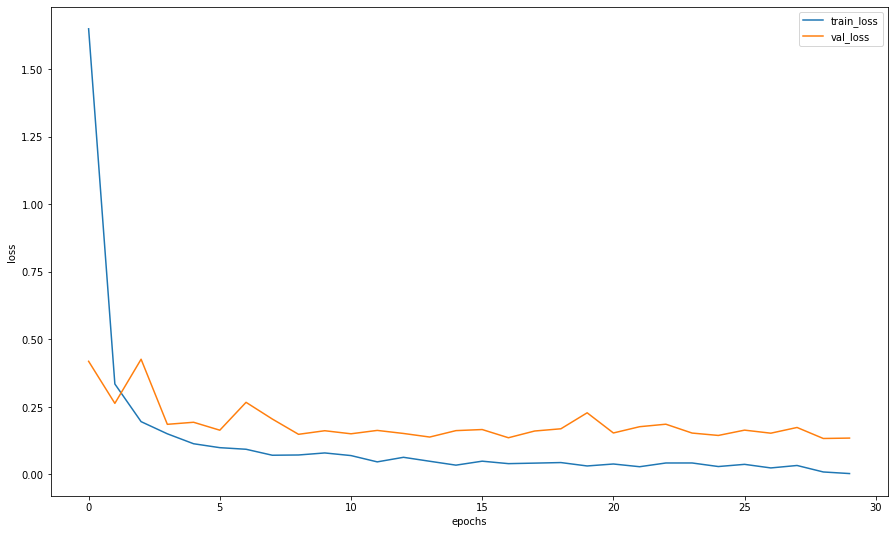

In [28]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [29]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [30]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(model, ex_img.unsqueeze(0))

In [ ]:
idxs = list(map(int, np.random.uniform(0,1000, 1000)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(model, imgs)
print(np.argmax(probs_ims,-1))

In [32]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [33]:
y_pred = np.array(np.argmax(probs_ims,-1))

actual_labels = np.array([val_dataset[id][1] for id in idxs])

preds_class = [label_encoder.classes_[i] for i in y_pred]

Посмотрим по метрике f1 нашу точность


In [34]:
from sklearn.metrics import f1_score

#f1_score(actual_labels, preds_class)
f1_score(actual_labels, y_pred, average='micro')

0.982

Не так уж и плохо для обычной ResNet50, на которой переобучили только последний слой классификатора.


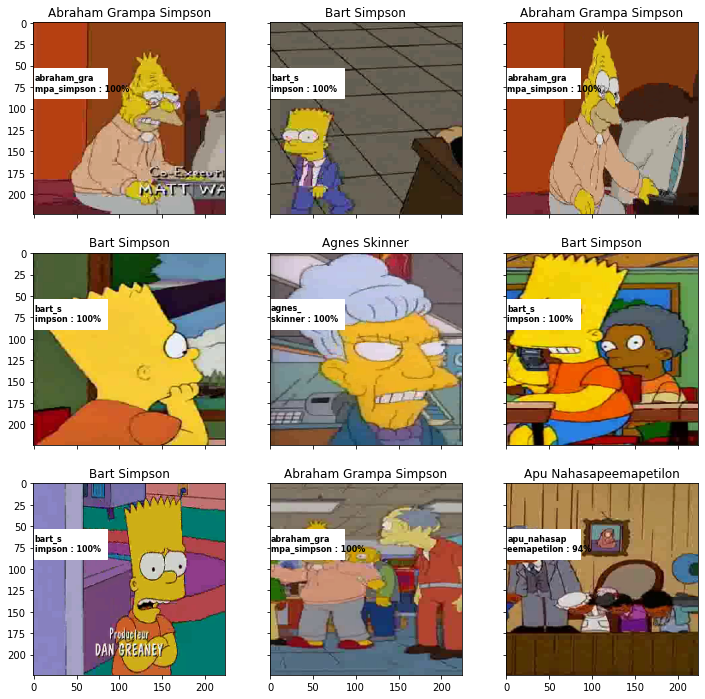

In [35]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(model, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left',
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

In [36]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
print(test_files)
probs = predict(model, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]


[PosixPath('testset/testset/img0.jpg'), PosixPath('testset/testset/img1.jpg'), PosixPath('testset/testset/img10.jpg'), PosixPath('testset/testset/img100.jpg'), PosixPath('testset/testset/img101.jpg'), PosixPath('testset/testset/img102.jpg'), PosixPath('testset/testset/img103.jpg'), PosixPath('testset/testset/img104.jpg'), PosixPath('testset/testset/img105.jpg'), PosixPath('testset/testset/img106.jpg'), PosixPath('testset/testset/img107.jpg'), PosixPath('testset/testset/img108.jpg'), PosixPath('testset/testset/img109.jpg'), PosixPath('testset/testset/img11.jpg'), PosixPath('testset/testset/img110.jpg'), PosixPath('testset/testset/img111.jpg'), PosixPath('testset/testset/img112.jpg'), PosixPath('testset/testset/img113.jpg'), PosixPath('testset/testset/img114.jpg'), PosixPath('testset/testset/img115.jpg'), PosixPath('testset/testset/img116.jpg'), PosixPath('testset/testset/img117.jpg'), PosixPath('testset/testset/img118.jpg'), PosixPath('testset/testset/img119.jpg'), PosixPath('testset/te

In [37]:
! ls 

characters_illustration.png  label_encoder.pkl	sample_submission.csv  train
gdrive			     sample_data	testset


In [39]:
import pandas as pd
df = pd.DataFrame()
df['Id'] = test_filenames
df['Expected'] = preds
df.to_csv('gdrive/My Drive/simpsons_resnet_baseline.csv', index=False)

In [ ]:
# TODO : сделайте сабмит (это важно, если Вы не справляетесь, но дошли до этой ячейки, то сообщите в чат и Вам помогут)

In [ ]:
#my_submit.to_csv('gdrive/My Drive/simpsons/resnet_baseline.csv', index=False)